# **Face Mask Detection**

In this notebook I am going to detect the face covering on a person. I have a dataset of 20 different labels like face_with_mask, no_mask, hijab, helmet, sunglasss, hat, etc.

In [5]:
import numpy as np## linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import cv2#to solve computer vision problems.
import matplotlib.pyplot as plt#reates a figure, creates a plotting area in a figure, plots some lines in a plotting area,
import matplotlib.patches as patches#A patch is a 2D artist with a face color and an edge color.
from tensorflow.keras.preprocessing.image import load_img, img_to_array#Converts a PIL Image instance to a Numpy array.
import os#This module provides a portable way of using operating system dependent functionality.
import tensorflow as tf#Tensorflow bundles together Machine Learning and Deep Learning models and algorithms

# Load data

In [6]:
img_path=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images")
anno_path=os.path.join("/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations")
train_df = pd.read_csv('../input/face-mask-detection-dataset/train.csv')
submission = pd.read_csv('../input/face-mask-detection-dataset/submission.csv')
print(len(os.listdir(img_path)))
print(len(os.listdir(anno_path)))

6024
4326


In [7]:
#sorting images based on indexes
images=os.listdir(img_path)
annot=os.listdir(anno_path)
images.sort()
annot.sort()

# **Train/Test Split**

In [8]:
train_images=images[1698:]
test_images=images[:1698]

#  Let us visualize a few examples!

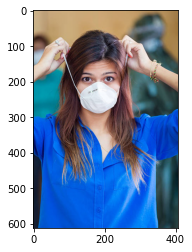

In [9]:
img=plt.imread(os.path.join(img_path,train_images[3]))
plt.imshow(img)
plt.show()

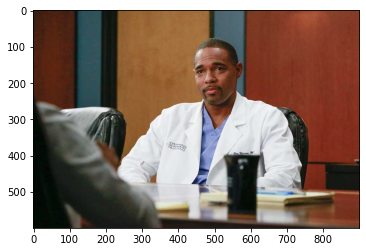

In [10]:
img=plt.imread(os.path.join(img_path,train_images[10]))
plt.imshow(img)
plt.show()

In [11]:
train_df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [12]:
train_df['name'].nunique()

4326

In [13]:
#Total classes
train_df['classname'].nunique()

20

#  Listing all different categories

In [14]:
train_df['classname'].value_counts()

face_with_mask              4180
mask_surgical               2430
mask_colorful               1876
face_no_mask                1569
face_other_covering         1372
eyeglasses                   914
hat                          823
sunglasses                   358
hair_net                     287
scarf_bandana                260
goggles                      192
helmet                       187
hijab_niqab                  173
face_shield                  160
hood                         159
face_with_mask_incorrect     150
balaclava_ski_mask           134
turban                        94
gas_mask                      55
other                         39
Name: classname, dtype: int64

# This shows a single picture might contain more than one person

In [15]:
train_df['name'].value_counts().max()

37

# Let us find and plot this image

In [16]:
train_df.groupby(['name']).count().sort_values(['x1'])

,x1,x2,y1,y2,classname
name,,,,,
1801.jpg,1,1,1,1,1
5680.jpg,1,1,1,1,1
5681.jpg,1,1,1,1,1
5683.jpg,1,1,1,1,1
5687.jpg,1,1,1,1,1
...,...,...,...,...,...
4141.png,27,27,27,27,27
3468.png,28,28,28,28,28
2422.png,32,32,32,32,32


# Let us define a function to draw boxes around the faces

In [17]:
box=[]
for i in range(len(train_df)):
    arr=[]
    for j in train_df.iloc[i][['x1','x2','y1','y2']]:
        arr.append(j)
    box.append(arr)
train_df['box']=box

In [18]:
def get_boxes(id):
    boxes=[]
    for i in train_df[train_df["name"]==str(id)]["box"]:
        boxes.append(i)
    return boxes

In [43]:
print(get_boxes(train_images[0]))

[[451, 186, 895, 697]]


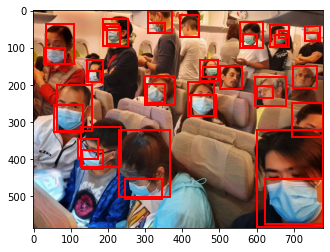

In [48]:
image = '1914.jpg'
img=plt.imread(os.path.join(img_path, image))
fig, ax = plt.subplots(1)
ax.imshow(img)
boxes=get_boxes(image)
for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

# **Data Preparation**

Cropping the images to the get face images. These facial shots will be used for model training for the classification task

In [21]:
img_size=50
x=[]
y=[]
for i in range(len(train_df)):
    arr=[]
    for item in train_df.iloc[i]:
        arr.append(item)
    img = cv2.imread(os.path.join(img_path, arr[0]), cv2.IMREAD_GRAYSCALE)
    img = img[arr[2]:arr[4], arr[1]:arr[3]]
    try:
        img = cv2.resize(img, (img_size, img_size))
    except:
        continue
    x.append(img)
    y.append(arr[5])

In [22]:
#Creating a seperate copy of data
x_mask=[]
y_mask=[]
for i in range(len(x)):
    x_mask.append(x[i])
    y_mask.append(y[i])

# Encoding the labels

In [23]:
from sklearn.preprocessing import LabelEncoder#Encode target labels with value between 0 and n_classes-1.This transformer should be used to encode target values, i.e. y, and not the input X.
lr = LabelEncoder()
y_mask = lr.fit_transform(y_mask)

In [24]:
#Normalizing the data
x_mask=np.array(x_mask).reshape(-1,50,50,1)
x_mask=tf.keras.utils.normalize(x_mask,axis=1)
from keras.utils import to_categorical#Converts a class vector (integers) to binary class matrix.
y_mask = to_categorical(y_mask)

Using TensorFlow backend.


# Model Training

In [25]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D#1)Dense layer is the regular deeply connected neural network layer.
#Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly,2)Flattens the input. Does not affect the batch size.

from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D#Max pooling operation for 2D spatial data.
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam#Optimizer that implements the Adam algorithm.
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau#Reduce learning rate when a metric has stopped improving.
from tensorflow.keras.utils import plot_model#Converts a Keras model to dot format and save to a file.
from tensorflow.keras.preprocessing.image import ImageDataGenerator#Generate batches of tensor image data with real-time data augmentation.

from IPython.display import SVG, Image

In [26]:
batch_size = 32#The batch size defines the number of samples that will be propagated through the network.

datagen_train = ImageDataGenerator(horizontal_flip=True, rotation_range=15,brightness_range=(0., 2.), shear_range=10)

train_generator = datagen_train.flow(x_mask, y_mask,batch_size=batch_size, shuffle=True)

# Initialising the CNN

In [27]:
# Initialising the CNN
model = Sequential()

# 1 - Convolution layer
model.add(Conv2D(64,(3,3), padding='same', input_shape=(50,50,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.2))

# 4th Convolution layer
model.add(Conv2D(1024,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(2048,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(20, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 50, 50, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       5

**Epoch 30/30 481/481 [==============================] - 18s 37ms/step - loss: 0.5152 - accuracy: 0.8136**

**Epoch 50/50 481/481 [==============================] - 17s 36ms/step - loss: 0.2501 - accuracy: 0.9112**

In [35]:
epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", save_weights_only=True, mode='max', verbose=1)
#callbacks = [PlotLossesKerasTF(), checkpoint]

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/50
481/481 [==============================] - 17s 36ms/step - loss: 0.5203 - accuracy: 0.8150
Epoch 2/50
481/481 [==============================] - 18s 38ms/step - loss: 0.5010 - accuracy: 0.8252
Epoch 3/50
481/481 [==============================] - 18s 37ms/step - loss: 0.4843 - accuracy: 0.8264
Epoch 4/50
481/481 [==============================] - 17s 35ms/step - loss: 0.4809 - accuracy: 0.8301
Epoch 5/50
481/481 [==============================] - 19s 39ms/step - loss: 0.4629 - accuracy: 0.8337
Epoch 6/50
481/481 [==============================] - 18s 37ms/step - loss: 0.4653 - accuracy: 0.8315
Epoch 7/50
481/481 [==============================] - 18s 36ms/step - loss: 0.4460 - accuracy: 0.8424
Epoch 8/50
481/481 [==============================] - 18s 38ms/step - loss: 0.4381 - accuracy: 0.8419
Epoch 9/50
481/481 [==============================] - 19s 39ms/step - loss: 0.4292 - accuracy: 0.8471
Epoch 10/50
481/481 [==============================] - 17s 36ms/step - loss: 0.430

# Training loss & Accuracy plot

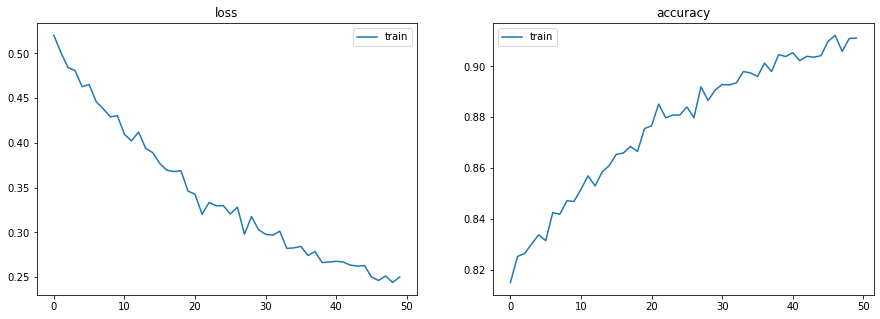

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='train')
#axes[0].plot(history.history['val_loss'], label='val')
axes[0].set_title('loss')
axes[0].legend()
axes[1].plot(history.history['accuracy'], label='train')
#axes[1].plot(history.history['val_accuracy'], label='val')
axes[1].set_title('accuracy')
axes[1].legend()

# To detect and localize the facial images from the input images we will be using the MTCNN model

In [37]:
pip install mtcnn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
from mtcnn.mtcnn import MTCNN#By default the MTCNN bundles a face detection weights model.

In [39]:
def predict(pic):
    detector=MTCNN()
    img = plt.imread(pic)
    inp=cv2.imread(pic, cv2.IMREAD_GRAYSCALE)
    faces = detector.detect_faces(img)
    for face in faces:
        bounding_box = face['box']
        inp = inp[bounding_box[1]:bounding_box[1]+bounding_box[3], bounding_box[0]:bounding_box[0]+bounding_box[2]]
        cv2.rectangle(img,(bounding_box[0], bounding_box[1]),(bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                          (0,155,255),
                          10)
        try:
            inp=cv2.resize(inp,(50,50))
        except:
            break
        inp=inp.reshape(-1,50,50,1)
        pred=model.predict(inp)
        print(lr.inverse_transform([np.argmax(pred)])[0])
    plt.imshow(img)

face_with_mask


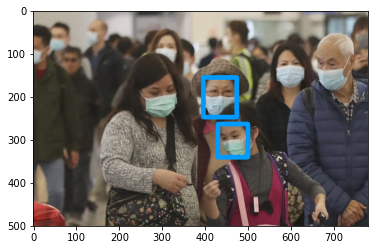

In [40]:
predict(os.path.join(img_path, test_images[22]))